# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


 ## Imports
 

In [1]:
import imageio
imageio.plugins.ffmpeg.download()
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.


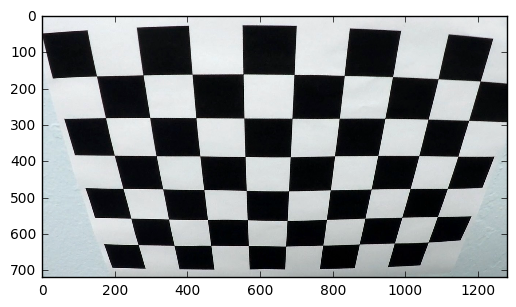

In [2]:
#Lets see a sample calibration image
image= cv2.imread('camera_cal/calibration2.jpg')

plt.imshow(image)
plt.show()


In [3]:
#visually analysing the calibration images shows 6*9 corners so we will create a object array of 6*9*3 shape
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        print('loaded')
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
        

#cv2.destroyAllWindows()



loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded


In [4]:
#Calibrate camera using the Objectpoints and imagepoints above and save to a pickel file so we can simply re-use if we want
img = cv2.imread('camera_cal/calibration1.jpg')

img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )




# Apply a distortion correction to raw images.


In [5]:
def undistortImage(distorted):
    dst = cv2.undistort(distorted, mtx, dist, None, mtx)
    return dst


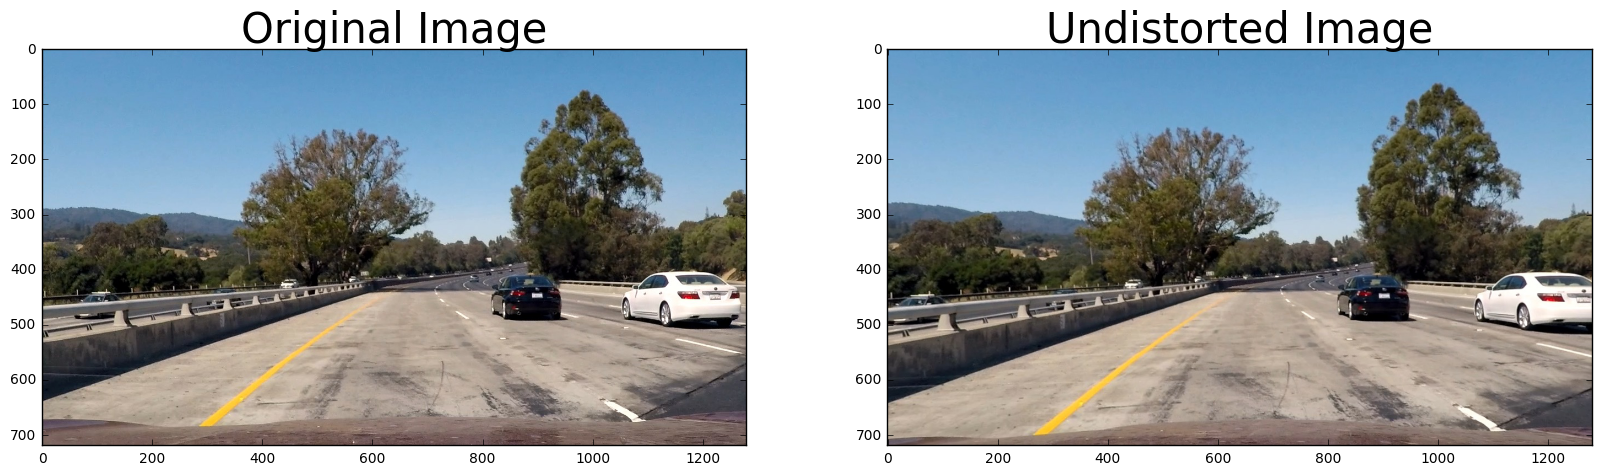

In [6]:
# Example undistortion
img = plt.imread('test_images/test1.jpg')

dst = undistortImage(img)
#cv2.imwrite('test_images/test_undist.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

# Use color transforms, gradients, etc., to create a thresholded binary image.


In [7]:
def abs_sobel_thresh(sourceImg, orient='x',sobel_kernel=3, thresh_min=20, thresh_max=255):
    
    # Apply the following steps to img
    
    # 1) Convert to grayscale
    gray= cv2.cvtColor(sourceImg,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    if orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary


In [8]:
def mag_thresh(sourceImg, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(sourceImg, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
     # 3) Calculate the magnitude 
    sobelxy=np.sqrt(sobelx**2+ sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    abs_sobelxy = np.absolute(sobelxy)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [9]:
def dir_threshold(sourceImg, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray= cv2.cvtColor(sourceImg,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gradient=np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(gradient)
    sxbinary[(gradient >= thresh[0]) & (gradient <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    binary_output = np.copy(img) # Remove this line
    return sxbinary
    

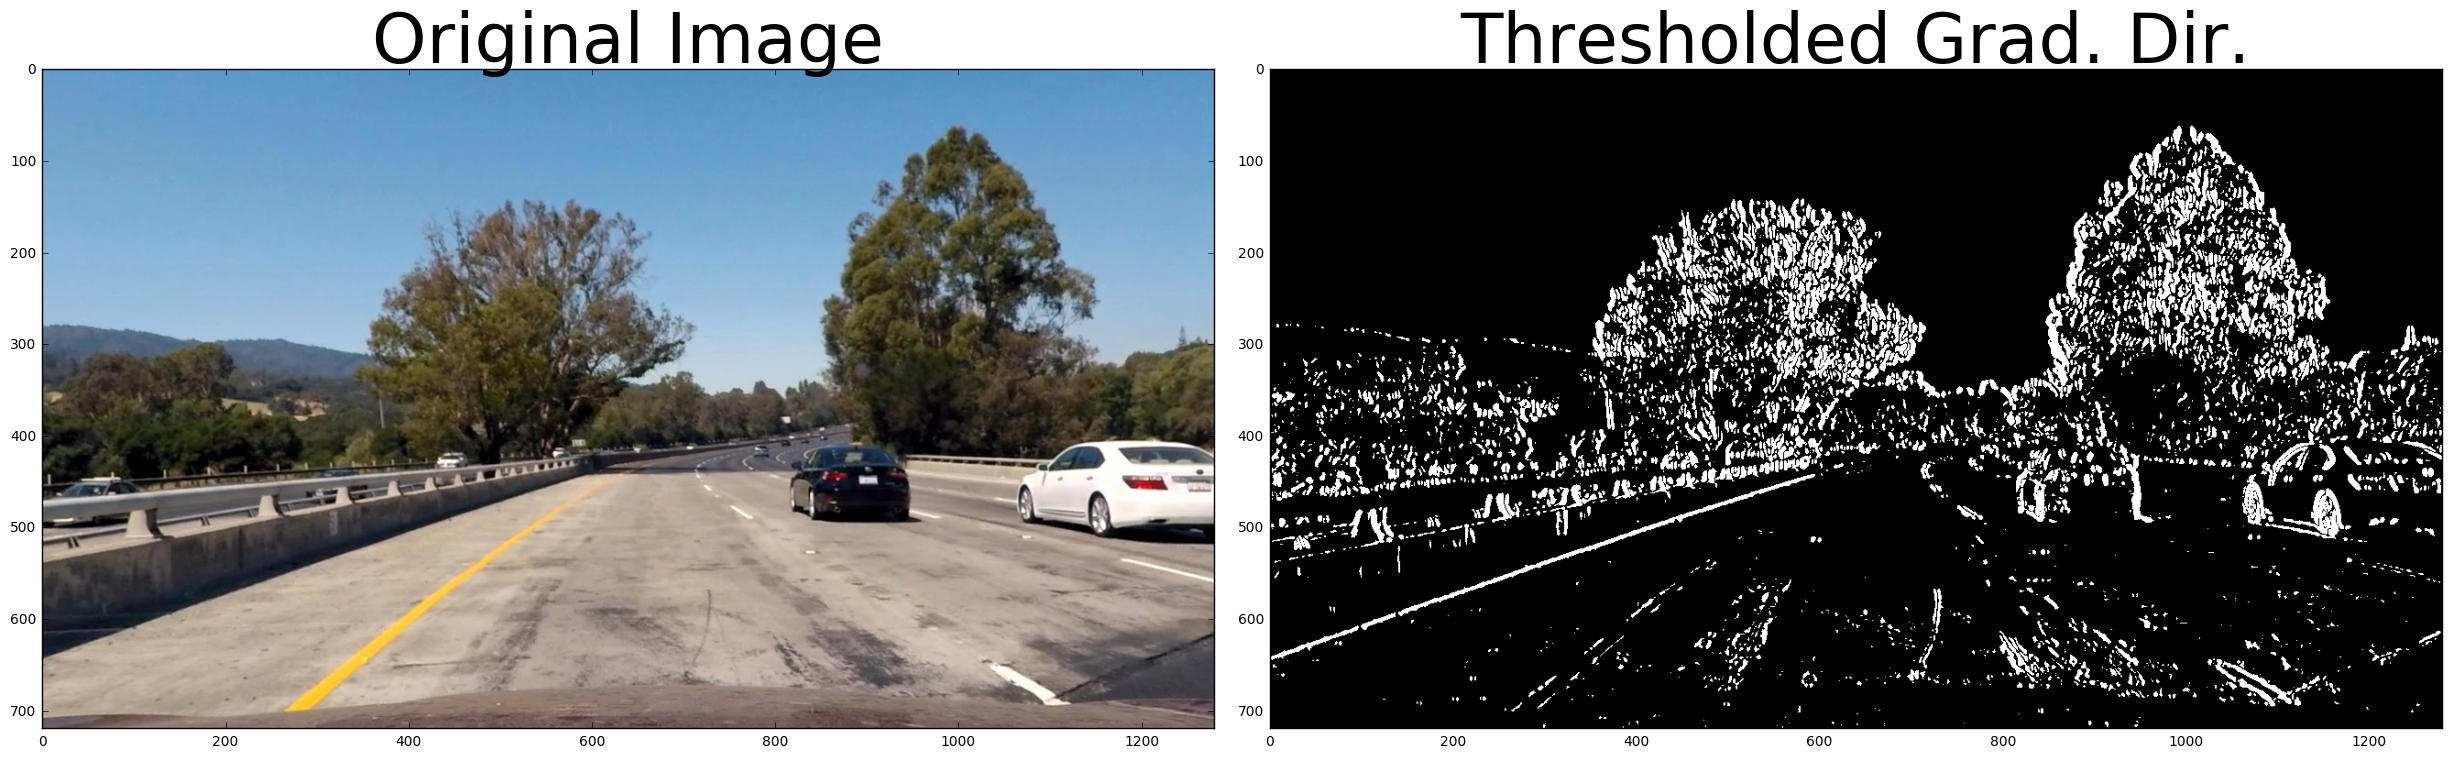

In [10]:
image=dst
ksize=9

def applyGradient(sourceImage):
    gradx = abs_sobel_thresh(sourceImage, orient='x', sobel_kernel=ksize)
    grady = abs_sobel_thresh(sourceImage, orient='y', sobel_kernel=ksize)
    mag_binary = mag_thresh(sourceImage, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(sourceImage, sobel_kernel=ksize, thresh=(0, 1))

    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) ) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

gradientImage= applyGradient(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(gradientImage,cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


# Color Gradients


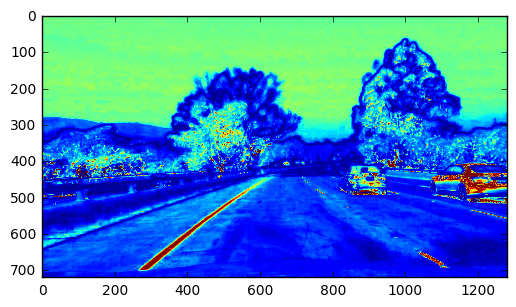

In [11]:
#HLS
#We've seen in the examples that S space of the HLS color space performs the best so lets test with that first

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
plt.imshow(hls)
H = hls[:,:,0]
L = hls[:,:,1]
S=  hls[:,:,2]

plt.imshow(S)
plt.show()

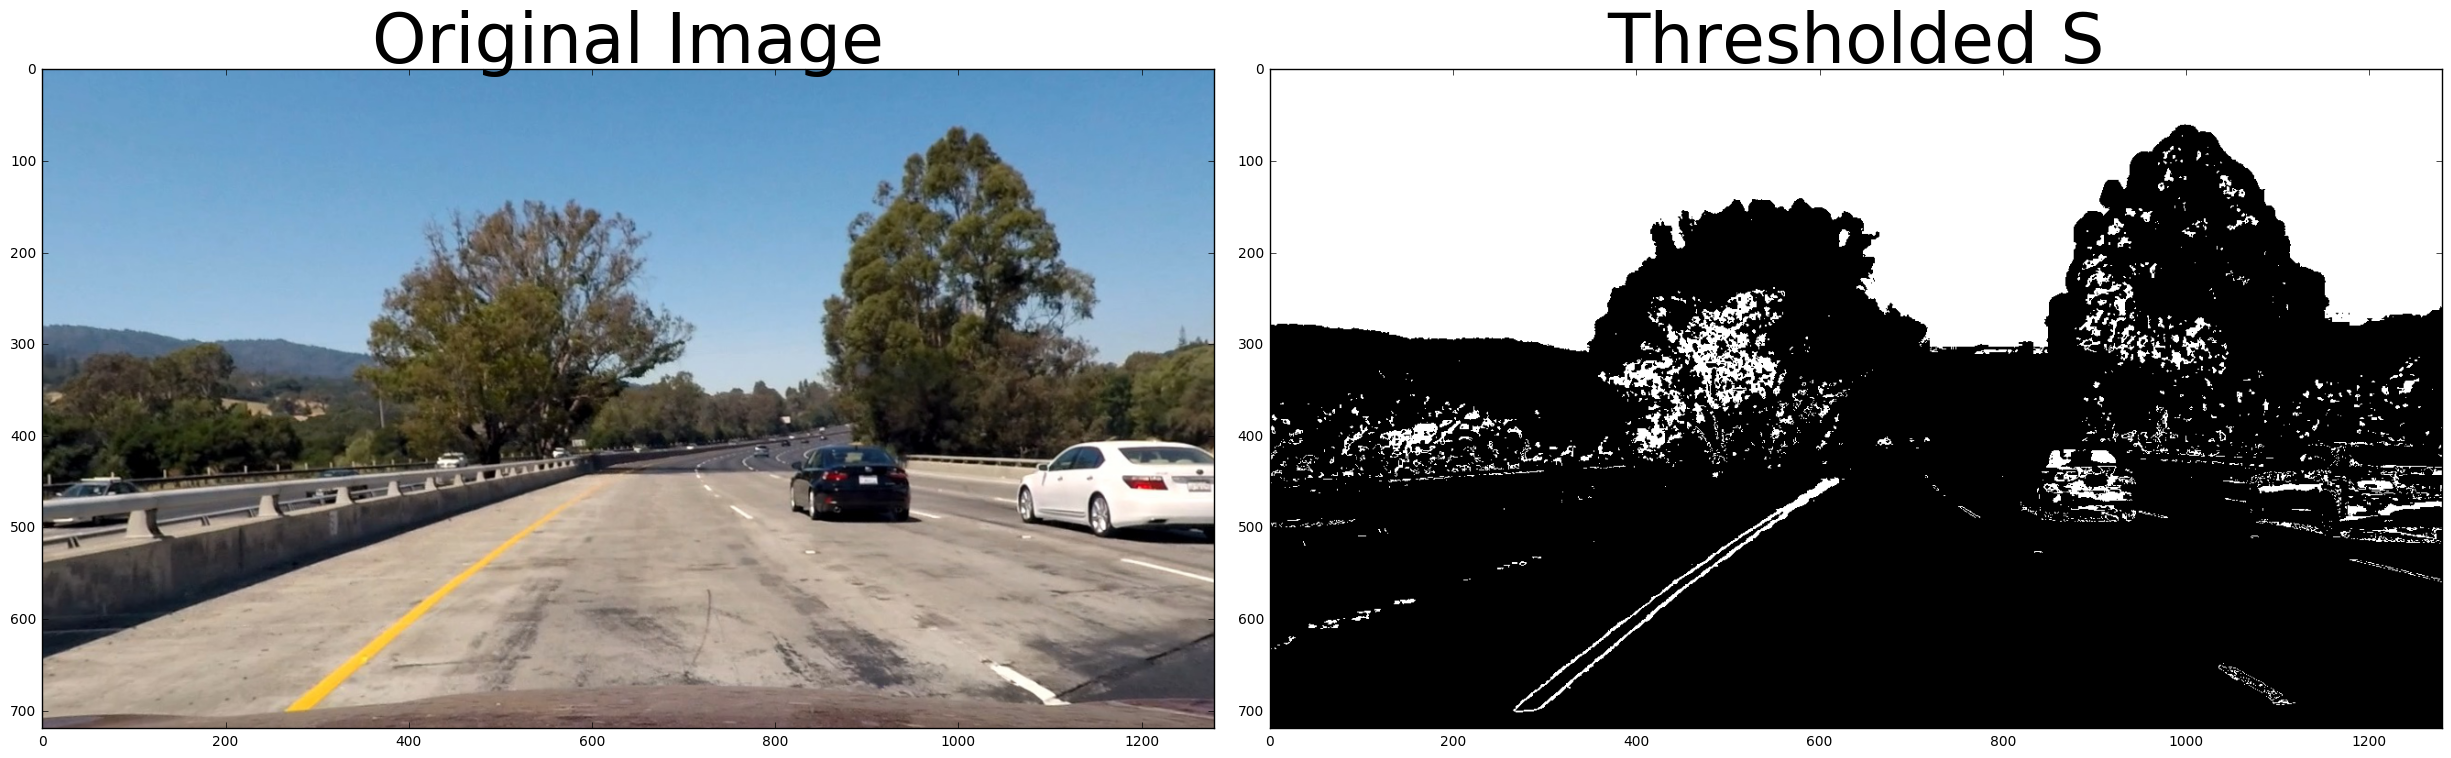

In [12]:
def hls_select(sourceImage, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls=  cv2.cvtColor(sourceImage, cv2.COLOR_RGB2HLS)

    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    sxbinary = np.zeros_like(S)
    sxbinary[(S > thresh[0]) & (S <=thresh[1])] = 1

    # 3) Return a binary image of threshold result
    return sxbinary
    
hls_binary = hls_select(image, thresh=(100, 200))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

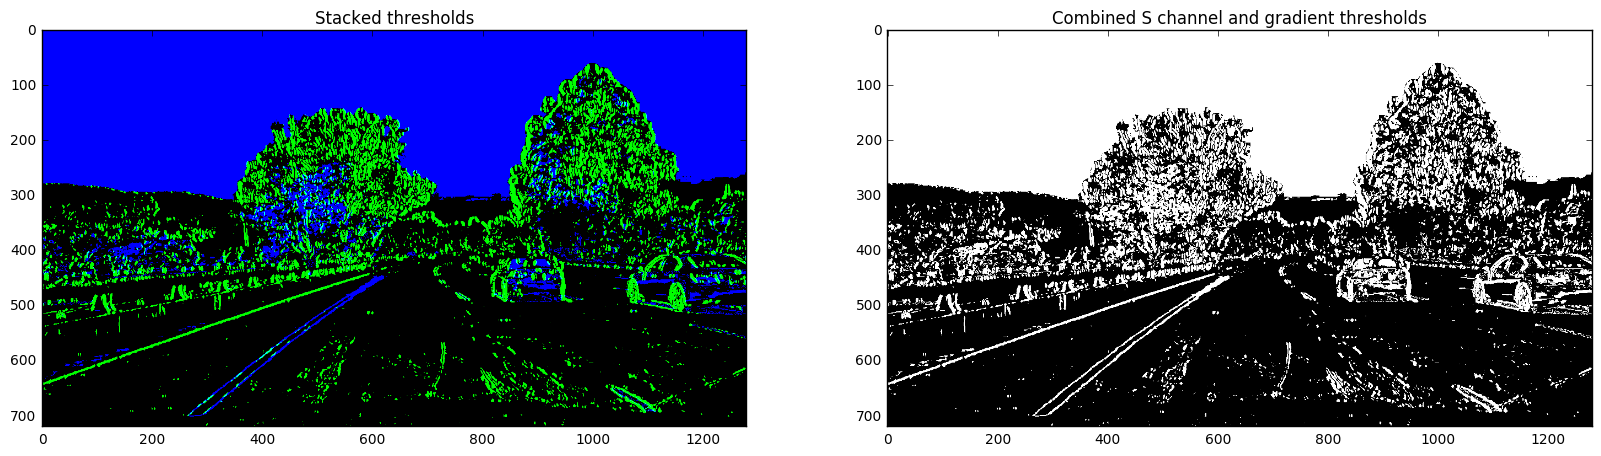

In [13]:
def getCombinedGradientImage(gradientSourceImage, hls_Source_binary):

# Combine the two binary thresholds
    combined_binary = np.zeros_like(gradientSourceImage)
    combined_binary[(hls_Source_binary == 1) | (gradientSourceImage == 1)] = 1
    return combined_binary

color_binary = np.dstack(( np.zeros_like(gradientImage), gradientImage, hls_binary))

combined_binary= getCombinedGradientImage(gradientImage, hls_binary)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.show()

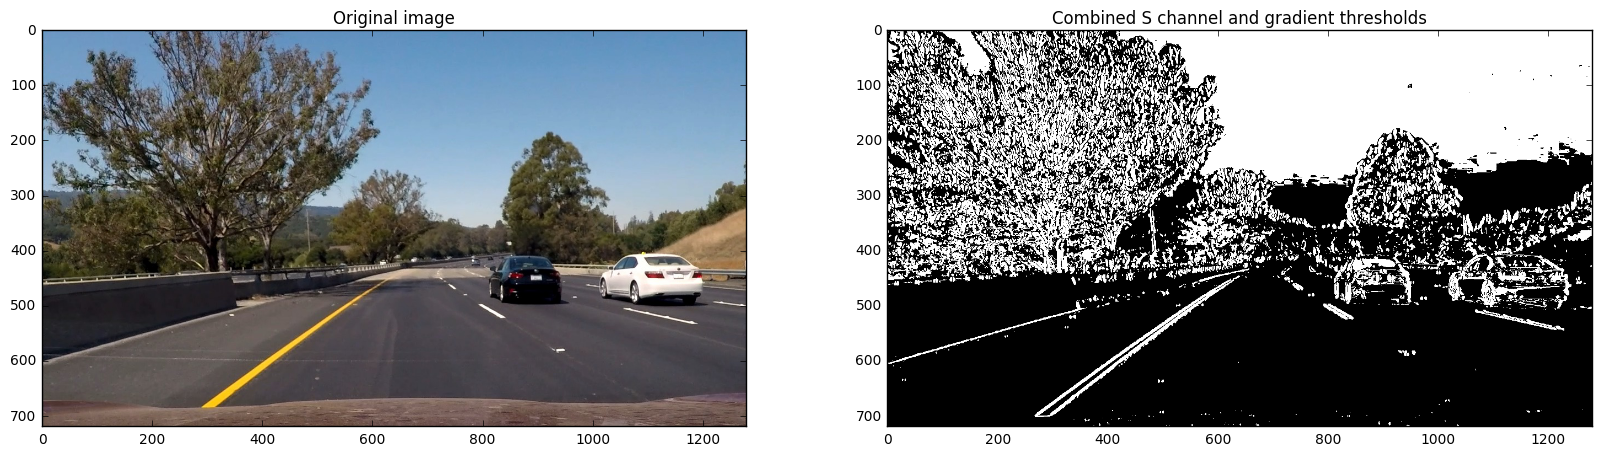

In [14]:
# Test various images
test = plt.imread('test_images/test6.jpg')

test_dst = undistortImage(test)
test_gradient=applyGradient(test_dst)
test_hls_binary = hls_select(test_dst, thresh=(100, 200))
combined= getCombinedGradientImage(test_gradient,test_hls_binary)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original image')
ax1.imshow(test)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined, cmap='gray')
plt.show()


# Perspective Transform:- * Apply a perspective transform to rectify binary image ("birds-eye view").


In [15]:
#define source and dest points
h,w = dst.shape[:2]

# define source and destination points for transform
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])


In [16]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, Minv, 



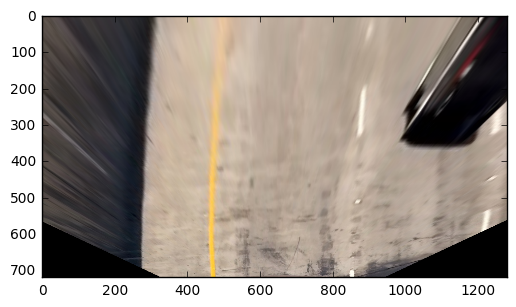

In [17]:
unwarpedImage, M =unwarp(image,src,dst)
plt.imshow(unwarpedImage)
plt.show()

# Check current implementation to see the pipeline so far



In [18]:
def pipeline(image):
    undistort= undistortImage(image)
    gradientImage=applyGradient(undistort)
    hls_binary = hls_select(undistort, thresh=(100, 200))
    combined_binary= getCombinedGradientImage(gradientImage, hls_binary)
    unwarped, M= unwarp(combined_binary,src,dst)
    return unwarped,M

    
    
    

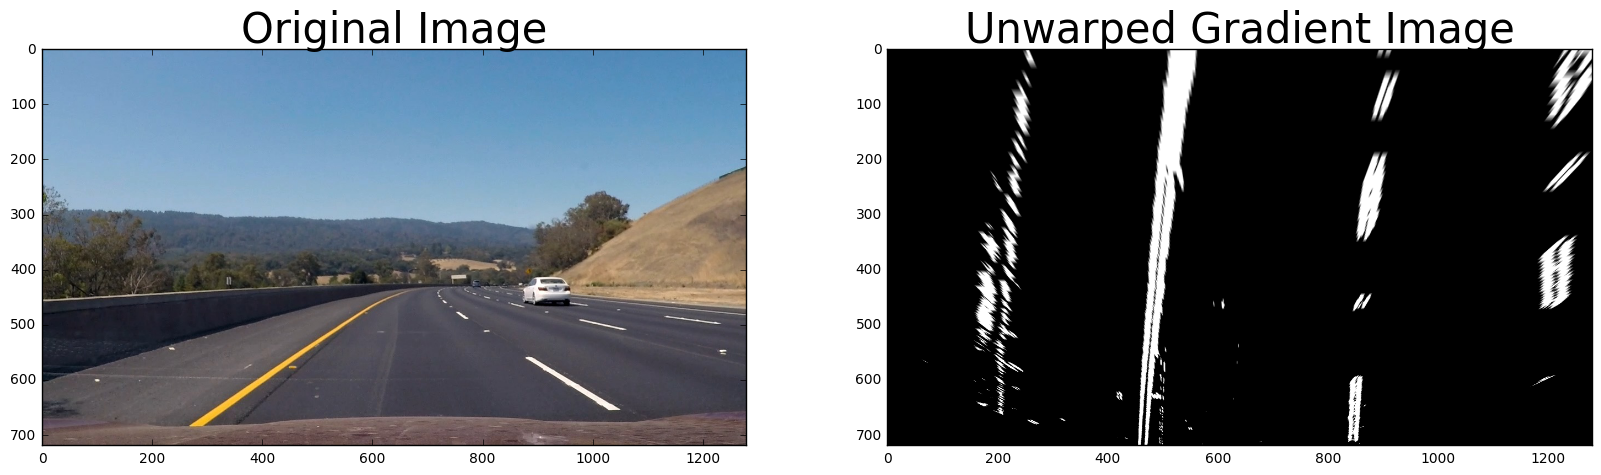

In [19]:
test_image = plt.imread('test_images/test3.jpg')

unwarpedTest,M= pipeline(test_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(unwarpedTest, cmap='gray')
ax2.set_title('Unwarped Gradient Image', fontsize=30)
plt.show()

In [20]:
# Make a list of example images
images = glob.glob('test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_bin,MinVal = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1
    

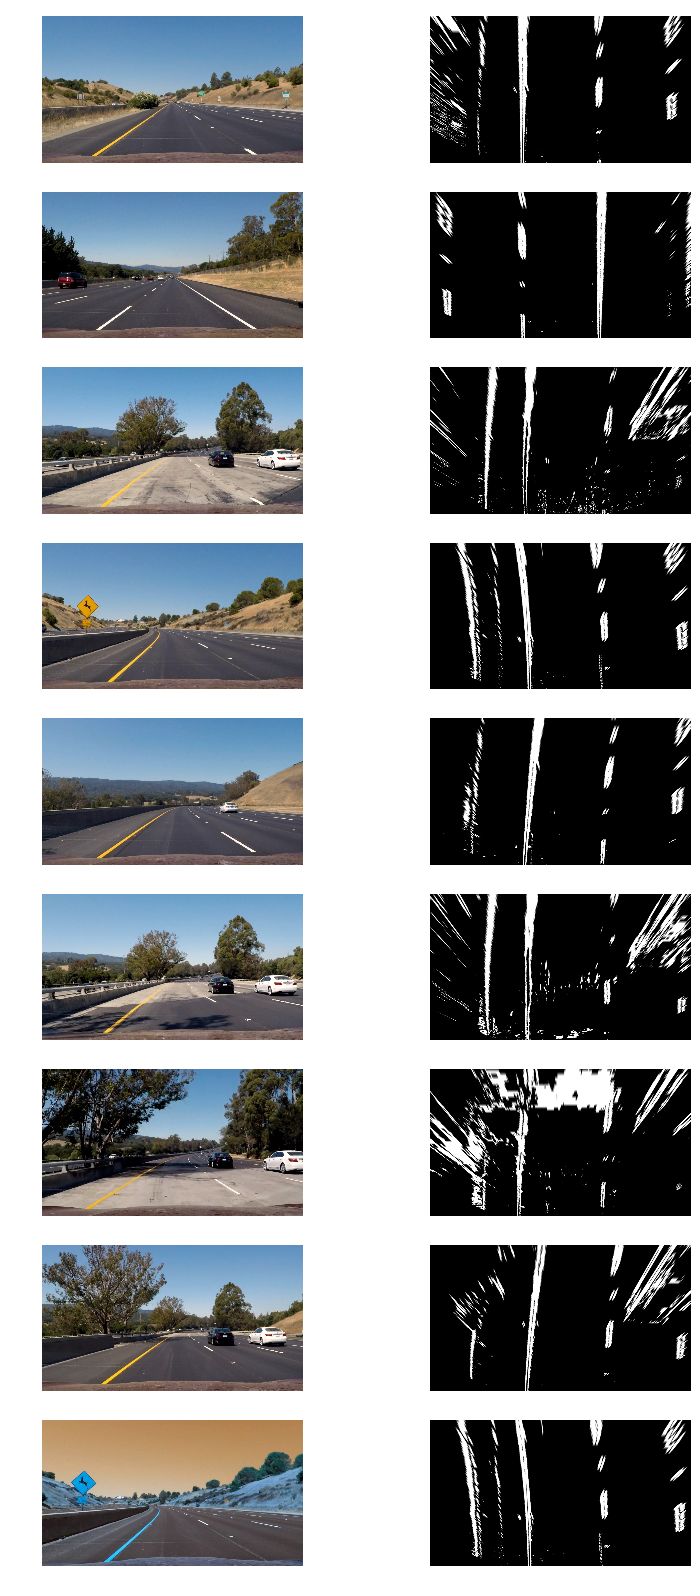

In [21]:
plt.show()

# Detect lane pixels and fit to find the lane boundary.


In [22]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data


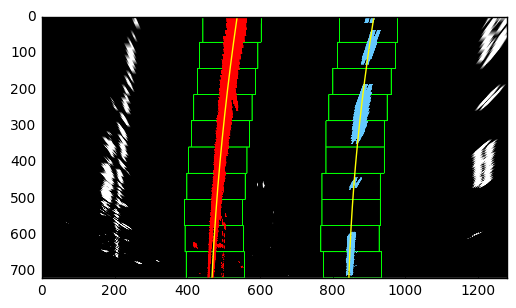

In [23]:
# visualize the result on example image
exampleImg = cv2.imread('test_images/test3.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin,exampleImage_MinVal = pipeline(exampleImg)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()



In [24]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


In [25]:
# visualize the result on example image
exampleImg2 = cv2.imread('test_images/test3.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin, M = pipeline(exampleImg2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(720, 0)

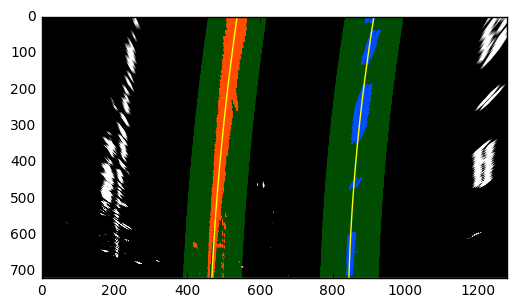

In [26]:
plt.show()

# Determine the curvature of the lane and vehicle position with respect to center.


In [27]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist


In [28]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius', rad_l, 'm,', rad_r, 'm')
print('Distance', d_center, 'm')

Radius 693.2983923 m, 523.862747562 m
Distance -0.161717530962 m


# Warp the detected lane boundaries back onto the original image.


In [29]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result


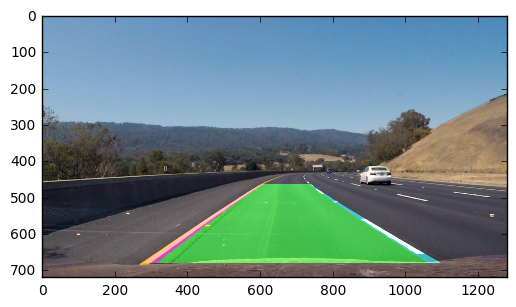

In [30]:
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, exampleImage_MinVal)
plt.imshow(exampleImg_out1)
plt.show()

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [31]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img


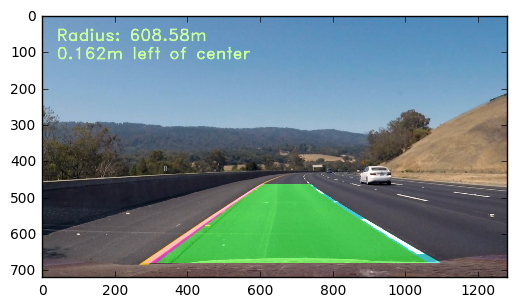

In [32]:
exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out2)
plt.show()


In [33]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


            


In [36]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        print('sliding window detection')
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 50 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 50:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out


In [34]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img


In [37]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output4.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

sliding window detection
[MoviePy] >>>> Building video project_video_output4.mp4
[MoviePy] Writing video project_video_output4.mp4


  7%|▋         | 88/1261 [00:41<08:38,  2.26it/s]

sliding window detection


 13%|█▎        | 162/1261 [01:12<07:25,  2.47it/s]

sliding window detection


 13%|█▎        | 163/1261 [01:13<07:29,  2.44it/s]

sliding window detection


 13%|█▎        | 164/1261 [01:13<07:29,  2.44it/s]

sliding window detection


 15%|█▍        | 185/1261 [01:23<07:31,  2.38it/s]

sliding window detection


 15%|█▍        | 186/1261 [01:23<07:30,  2.39it/s]

sliding window detection


 16%|█▌        | 201/1261 [01:29<07:18,  2.42it/s]

sliding window detection


 16%|█▌        | 202/1261 [01:30<07:13,  2.44it/s]

sliding window detection


 22%|██▏       | 272/1261 [01:58<06:44,  2.45it/s]

sliding window detection


 24%|██▍       | 307/1261 [02:12<06:38,  2.39it/s]

sliding window detection


 25%|██▍       | 309/1261 [02:13<06:33,  2.42it/s]

sliding window detection


 33%|███▎      | 419/1261 [02:58<05:36,  2.50it/s]

sliding window detection


 40%|███▉      | 503/1261 [03:33<05:36,  2.25it/s]

sliding window detection


 43%|████▎     | 545/1261 [03:50<04:51,  2.46it/s]

sliding window detection


 43%|████▎     | 546/1261 [03:51<04:54,  2.43it/s]

sliding window detection


 43%|████▎     | 547/1261 [03:51<04:59,  2.38it/s]

sliding window detection


 43%|████▎     | 548/1261 [03:51<04:59,  2.38it/s]

sliding window detection


 44%|████▎     | 549/1261 [03:52<05:00,  2.37it/s]

sliding window detection


 44%|████▎     | 550/1261 [03:52<04:58,  2.38it/s]

sliding window detection


 44%|████▎     | 551/1261 [03:53<04:56,  2.40it/s]

sliding window detection


 44%|████▍     | 552/1261 [03:53<05:00,  2.36it/s]

sliding window detection


 44%|████▍     | 553/1261 [03:54<04:57,  2.38it/s]

sliding window detection


 45%|████▌     | 569/1261 [04:00<04:42,  2.45it/s]

sliding window detection


 45%|████▌     | 570/1261 [04:01<04:42,  2.44it/s]

sliding window detection


 45%|████▌     | 572/1261 [04:01<04:48,  2.39it/s]

sliding window detection


 45%|████▌     | 573/1261 [04:02<04:45,  2.41it/s]

sliding window detection


 46%|████▌     | 574/1261 [04:02<04:42,  2.43it/s]

sliding window detection


 46%|████▌     | 575/1261 [04:03<04:47,  2.39it/s]

sliding window detection


 46%|████▌     | 576/1261 [04:03<04:43,  2.41it/s]

sliding window detection


 46%|████▌     | 577/1261 [04:03<04:42,  2.42it/s]

sliding window detection


 46%|████▌     | 578/1261 [04:04<04:38,  2.45it/s]

sliding window detection


 46%|████▌     | 579/1261 [04:04<04:37,  2.46it/s]

sliding window detection


 46%|████▌     | 581/1261 [04:05<04:40,  2.43it/s]

sliding window detection


 46%|████▌     | 582/1261 [04:06<04:37,  2.45it/s]

sliding window detection


 46%|████▌     | 583/1261 [04:06<04:43,  2.39it/s]

sliding window detection


 46%|████▋     | 584/1261 [04:06<04:41,  2.41it/s]

sliding window detection


 46%|████▋     | 585/1261 [04:07<04:38,  2.42it/s]

sliding window detection


 46%|████▋     | 586/1261 [04:07<04:37,  2.43it/s]

sliding window detection


 47%|████▋     | 587/1261 [04:08<04:33,  2.46it/s]

sliding window detection


 47%|████▋     | 588/1261 [04:08<04:34,  2.45it/s]

sliding window detection


 47%|████▋     | 589/1261 [04:08<04:36,  2.43it/s]

sliding window detection


 47%|████▋     | 590/1261 [04:09<04:37,  2.42it/s]

sliding window detection


 47%|████▋     | 591/1261 [04:09<04:35,  2.43it/s]

sliding window detection


 47%|████▋     | 592/1261 [04:10<04:38,  2.40it/s]

sliding window detection


 47%|████▋     | 593/1261 [04:10<04:39,  2.39it/s]

sliding window detection


 47%|████▋     | 598/1261 [04:12<04:46,  2.32it/s]

sliding window detection


 48%|████▊     | 599/1261 [04:13<04:58,  2.22it/s]

sliding window detection


 48%|████▊     | 600/1261 [04:13<04:57,  2.22it/s]

sliding window detection


 48%|████▊     | 601/1261 [04:14<05:38,  1.95it/s]

sliding window detection


 48%|████▊     | 602/1261 [04:14<06:06,  1.80it/s]

sliding window detection


 48%|████▊     | 603/1261 [04:15<05:57,  1.84it/s]

sliding window detection


 48%|████▊     | 604/1261 [04:15<05:48,  1.89it/s]

sliding window detection


 48%|████▊     | 608/1261 [04:17<05:26,  2.00it/s]

sliding window detection


 48%|████▊     | 609/1261 [04:18<05:09,  2.10it/s]

sliding window detection


 48%|████▊     | 610/1261 [04:18<05:02,  2.15it/s]

sliding window detection


 48%|████▊     | 611/1261 [04:19<04:55,  2.20it/s]

sliding window detection


 49%|████▊     | 612/1261 [04:19<04:48,  2.25it/s]

sliding window detection


 49%|████▊     | 613/1261 [04:20<04:41,  2.30it/s]

sliding window detection


 49%|████▊     | 614/1261 [04:20<04:38,  2.32it/s]

sliding window detection


 49%|████▉     | 615/1261 [04:20<04:38,  2.32it/s]

sliding window detection


 49%|████▉     | 616/1261 [04:21<04:35,  2.34it/s]

sliding window detection


 49%|████▉     | 620/1261 [04:23<04:29,  2.38it/s]

sliding window detection


 49%|████▉     | 621/1261 [04:23<04:29,  2.38it/s]

sliding window detection


 50%|████▉     | 630/1261 [04:27<04:31,  2.32it/s]

sliding window detection


 50%|█████     | 632/1261 [04:28<04:43,  2.22it/s]

sliding window detection


 50%|█████     | 633/1261 [04:28<04:39,  2.25it/s]

sliding window detection


 50%|█████     | 634/1261 [04:29<04:35,  2.28it/s]

sliding window detection


 50%|█████     | 635/1261 [04:29<04:35,  2.27it/s]

sliding window detection


 75%|███████▍  | 942/1261 [06:49<02:54,  1.83it/s]

sliding window detection


 76%|███████▌  | 954/1261 [06:54<02:19,  2.20it/s]

sliding window detection


 76%|███████▌  | 956/1261 [06:55<02:15,  2.24it/s]

sliding window detection


 76%|███████▌  | 957/1261 [06:56<02:16,  2.22it/s]

sliding window detection


 76%|███████▌  | 958/1261 [06:56<02:17,  2.20it/s]

sliding window detection


 76%|███████▌  | 959/1261 [06:57<02:17,  2.19it/s]

sliding window detection


 77%|███████▋  | 966/1261 [07:00<02:14,  2.19it/s]

sliding window detection


 77%|███████▋  | 967/1261 [07:00<02:15,  2.17it/s]

sliding window detection


 77%|███████▋  | 968/1261 [07:01<02:13,  2.20it/s]

sliding window detection


 77%|███████▋  | 969/1261 [07:01<02:14,  2.18it/s]

sliding window detection


 77%|███████▋  | 970/1261 [07:02<02:13,  2.18it/s]

sliding window detection


 77%|███████▋  | 977/1261 [07:05<02:05,  2.27it/s]

sliding window detection


 78%|███████▊  | 978/1261 [07:05<02:04,  2.26it/s]

sliding window detection


 78%|███████▊  | 980/1261 [07:06<02:08,  2.19it/s]

sliding window detection


 78%|███████▊  | 982/1261 [07:07<02:06,  2.21it/s]

sliding window detection


 80%|████████  | 1014/1261 [07:21<01:50,  2.23it/s]

sliding window detection


 80%|████████  | 1015/1261 [07:22<01:51,  2.21it/s]

sliding window detection


 81%|████████  | 1016/1261 [07:22<01:50,  2.21it/s]

sliding window detection


 81%|████████  | 1017/1261 [07:23<01:50,  2.20it/s]

sliding window detection


 81%|████████  | 1019/1261 [07:24<01:50,  2.19it/s]

sliding window detection


 81%|████████  | 1020/1261 [07:24<01:48,  2.22it/s]

sliding window detection


 81%|████████  | 1021/1261 [07:24<01:50,  2.18it/s]

sliding window detection


 81%|████████▏ | 1025/1261 [07:26<01:46,  2.22it/s]

sliding window detection


 81%|████████▏ | 1026/1261 [07:27<01:47,  2.19it/s]

sliding window detection


 81%|████████▏ | 1027/1261 [07:27<01:45,  2.22it/s]

sliding window detection


 82%|████████▏ | 1028/1261 [07:28<01:45,  2.20it/s]

sliding window detection


 82%|████████▏ | 1029/1261 [07:28<01:45,  2.20it/s]

sliding window detection


 82%|████████▏ | 1034/1261 [07:31<01:50,  2.06it/s]

sliding window detection


 82%|████████▏ | 1035/1261 [07:31<01:50,  2.05it/s]

sliding window detection


 82%|████████▏ | 1036/1261 [07:31<01:48,  2.07it/s]

sliding window detection


 82%|████████▏ | 1037/1261 [07:32<01:48,  2.06it/s]

sliding window detection


 82%|████████▏ | 1038/1261 [07:32<01:45,  2.11it/s]

sliding window detection


 82%|████████▏ | 1039/1261 [07:33<01:46,  2.09it/s]

sliding window detection


 82%|████████▏ | 1040/1261 [07:33<01:46,  2.08it/s]

sliding window detection


 83%|████████▎ | 1041/1261 [07:34<01:44,  2.10it/s]

sliding window detection


 83%|████████▎ | 1042/1261 [07:34<01:45,  2.08it/s]

sliding window detection


 84%|████████▎ | 1056/1261 [07:41<01:31,  2.25it/s]

sliding window detection


 84%|████████▍ | 1057/1261 [07:41<01:30,  2.24it/s]

sliding window detection


 85%|████████▍ | 1066/1261 [07:45<01:24,  2.30it/s]

sliding window detection


 98%|█████████▊| 1236/1261 [09:07<00:12,  2.07it/s]

sliding window detection


 98%|█████████▊| 1238/1261 [09:08<00:11,  2.06it/s]

sliding window detection


 99%|█████████▊| 1244/1261 [09:10<00:07,  2.26it/s]

sliding window detection


 99%|█████████▉| 1246/1261 [09:11<00:06,  2.25it/s]

sliding window detection


 99%|█████████▉| 1248/1261 [09:12<00:05,  2.23it/s]

sliding window detection


 99%|█████████▉| 1249/1261 [09:12<00:05,  2.24it/s]

sliding window detection


 99%|█████████▉| 1253/1261 [09:14<00:03,  2.29it/s]

sliding window detection


100%|█████████▉| 1255/1261 [09:15<00:02,  2.26it/s]

sliding window detection


100%|█████████▉| 1256/1261 [09:15<00:02,  2.26it/s]

sliding window detection


100%|█████████▉| 1257/1261 [09:16<00:01,  2.25it/s]

sliding window detection


100%|█████████▉| 1258/1261 [09:16<00:01,  2.26it/s]

sliding window detection


100%|█████████▉| 1259/1261 [09:17<00:00,  2.13it/s]

sliding window detection


100%|█████████▉| 1260/1261 [09:17<00:00,  2.09it/s]

sliding window detection


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output4.mp4 

CPU times: user 9min 42s, sys: 6.37 s, total: 9min 49s
Wall time: 9min 21s
